In [ ]:
# !pip install torchviz

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm
from torchviz import make_dot
import matplotlib.pyplot as plt

Этот код предназначен для создания, обучения и оценки простой нейронной сети на наборе данных FashionMNIST.
Основная цель - продемонстрировать процесс построения модели, её обучения и последующей оценки.

Ключевые этапы
- Загрузка и предобработка данных
- Определение и инициализация модели
- Обучение модели с вычислением функции потерь и обновлением весов
- Оценка модели на тестовом наборе данных
- Визуализация результатов обучения

Частично прокоментировал в коде плюс исправил ошибки

In [14]:
# В этой ячейке загружается датасет FashionMNIST и применяется преобразование для конвертации изображений в тензоры
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download=True, transform=transform)

In [15]:
# Создаются загрузчики данных для трейн и тест датасетов
# загрузчики нужны для управления пакетами данных во время тренировки и тестирования модели
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # shuffle=True делает данные более стохастическими
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# вытаскиваем один пакет из загрузчиков и смотрим формы данных
train_item = next(iter(train_loader))
test_item = next(iter(test_loader))
len(train_item), len(test_item), train_item[0].shape, train_item[1].shape

(2, 2, torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [17]:
# Определение нейронной сети с использованием PyTorch
class NNModel(nn.Module):
    def __init__(self,
                 layers_size = [49, 32, 16, 10],
                 dropout_prob = 1.0
                 ):
        super().__init__()
        # stride должен быть равен 4, чтобы получить нужный размер выходного изображения 
        # иначе будет ошибка mat1 and mat2 shapes cannot be multiplied
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=4) # свёрточный слой для уменьшения размера
        
        # ModuleList для правильной инициализации слоёв и нормализаций 
        # чтобы списки были частью структуры сети и учитывались в процессе обучения
        self.layers = nn.ModuleList([nn.Linear(layers_size[i], layers_size[i+1]) for i in range(len(layers_size)-1)])
        self.norm = nn.ModuleList([nn.BatchNorm1d(layers_size[i+1]) for i in range(len(layers_size)-2)])
        
        self.relu = nn.ReLU() # используется в качестве функции активации
        self.dropout = nn.Dropout(p=dropout_prob) # применяется для регуляризации сети и предотвращения переобучения

    def forward(self, batch): # прямое прохождение данных через сеть
        bs = batch.shape[0]
        batch = self.conv(batch).reshape(bs, -1)

        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                batch = self.dropout(self.relu(self.norm[i](layer(batch))))
            else:
                batch = layer(batch)
        return batch

    def print_net(self): # выводит структуру сети
        print(self.conv)
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                print(layer)
                print(self.norm[i])
                print(self.relu)
                print(self.dropout)
            else:
                print(layer)

        return

In [18]:
mlp  = NNModel(dropout_prob = 0.1) # экземпляр класса NNModel
# predictions = mlp(train_item[0])
# make_dot(predictions, params=dict(mlp.named_parameters()))
mlp.print_net() # выводит структуру модели

Conv2d(1, 1, kernel_size=(4, 4), stride=(4, 4))
Linear(in_features=49, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=16, out_features=10, bias=True)


train loss value = 0.6851466323838813
eval loss value = 0.5290395370714224
train loss value = 0.5656199088292335
eval loss value = 0.5481788312933248
train loss value = 0.5424804662082241
eval loss value = 0.47811997734057676
train loss value = 0.5291160343965488
eval loss value = 0.48553286265036105
train loss value = 0.5259576477348678
eval loss value = 0.4690584561247734
train loss value = 0.5180809218396765
eval loss value = 0.46740800569391555
train loss value = 0.5118729611958014
eval loss value = 0.45100860288188716
train loss value = 0.5070594935370153
eval loss value = 0.461846396801578
train loss value = 0.5052327287158986
eval loss value = 0.4493279912669188
train loss value = 0.49886117200416796
eval loss value = 0.43624918874661633


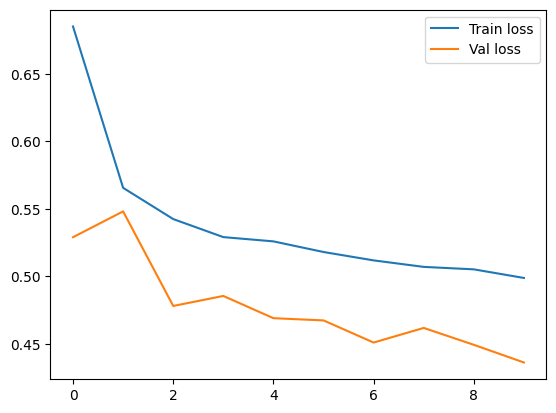

In [19]:
# Обучение и оценка модели
num_epochs = 10 # уменьшил итерации чтоб не ждать два года
DEBUG = True 
ce_loss = nn.CrossEntropyLoss() # функция потерь 
optimizer = torch.optim.Adam(mlp.parameters(), lr =  0.01) # оптимизатор 

logger = {'train':[],
          'eval' :[]
          } # словрь для хранения логов 
for epoch in range(num_epochs):

    epoch_stat = []

    # train part

    mlp.train() # режим обучения
    for batch in train_loader: # [train_item] -> train_loader, иначе обучение только на одном батче 

        images, labels = batch
        images, labels = images.float(), labels.long()
        predictions = mlp(images) # прогоняем значения через модель
        loss = ce_loss(predictions, labels) # вычисляем потери 

        # очистка градиентов перед обратным распространением, чтобы параметры правильно обновлялись
        optimizer.zero_grad() 
        loss.backward() # обратное распространение обновление параметров модели
        optimizer.step()

        epoch_stat.append(loss.item())

    if DEBUG: print(f"train loss value = {np.mean(epoch_stat)}")
    logger['train'].append(np.mean(epoch_stat))


    # eval part
    mlp.eval()  # установить модель в режим оценки
    with torch.no_grad():

        eval_stat = []
        for batch in test_loader: # [train_item] -> test_loader, иначе тест только на одном батче

            images, labels = batch
            images, labels = images.float(), labels.long()

            predictions = mlp(images)
            loss = ce_loss(predictions, labels) # на тестовом датасете вычисляем потери 
            # без обновления параметров

            # код не должен выполнять оптимизацию и обновление весов сети при оценке
            # это делается только при обучении
            # loss.backward() 
            # optimizer.step()

            eval_stat.append(loss.item())
    if DEBUG: print(f"eval loss value = {np.mean(eval_stat)}")
    logger['eval'].append(np.mean(eval_stat))

plt.plot(logger['train'], label='Train loss' )
plt.plot(logger['eval'], label='Val loss')
plt.legend()
plt.show()